In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [2]:
import numpy as np
# import torch, torchvision
# from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings

from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def get_traingroups(curr, stage):
    if curr=='dev':
        return 'g0g1g2'[:2*stage]
    elif curr=='adev':
        return 'g2g1g0'[:2*stage]
    
def parse_fname(fp):
# embeddings_adev_1_g2_default_0_246.csv'
    parts = Path(fp).stem.split('_')
    prefix, curr, stage, current_gr, cond, fold, seed = parts
    stage=int(stage)
    train_gr = get_traingroups(curr, stage)
    
    tag_dict = {
        'Curriculum':curr,
        'Stage': stage,
        'Condition':cond,
        'Seed': seed,
        'Train Groups': train_gr,
        'data_id': '_'.join([curr, seed, cond])
    }
    return tag_dict


def fix_iter(df, iter_per_epoch):
    df['Iteration'] = df['Iteration']+iter_per_epoch*(df['Epoch']-1)
    return df

def fix_iter2(df, iter_per_epoch, epoch_per_stage):
    df['Iteration'] = df['Iteration'] +iter_per_epoch*(df['Epoch']-1+epoch_per_stage*(df['Stage']-1))
    return df

def proc_fp_result(fp, epoch_per_stage=2, iter_per_epoch=2000, 
                  smooth_window=100):
    df = pd.read_csv(fp)
    tag_dict = parse_fname(fp)
    for tag in tag_dict.keys():
        df[tag] = tag_dict[tag]
    df = df.rename(columns={
    'epoch': 'Epoch',
    'itr': 'Iteration',
    'loss': 'Train Loss'
    })
#     print(df.columns)
    df = fix_iter2(df, iter_per_epoch,epoch_per_stage)
    df['Smooth Train Loss'] = df['Train Loss'].rolling(window=smooth_window, 
                                                       min_periods=1).mean()
    df['Train Loss Reduction'] = df['Smooth Train Loss'].diff(periods=-1)
#     df['Validation Loss Reduction'] = df['Validation Loss'].diff(periods=-1)
    return df


# epoch 	itr 	train loss 	val loss 	grad-EFL 	grad-ELL 	grad-DLL

In [5]:
date='aug1'
emb_root = '/N/project/baby_vision_curriculum/trained_models/predictive/v1/'+date+'/'
# aug1/'
# predictive/v1/jul315/'

# fpathlist = sorted([emb_root+fname
#                 for fname in os.listdir(emb_root)
#                 if Path(emb_root+fname).suffix=='.csv'])
fpathlist = sorted([emb_root+fname
                for fname in os.listdir(emb_root)
                if (Path(emb_root+fname).suffix=='.csv')])
#                     &(fname.split('.')[0].split('_')[-1]=='315')])

fpathlist

['/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_1_g2_default_0_111.csv',
 '/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_1_g2_default_1_112.csv',
 '/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_1_g2_default_2_113.csv',
 '/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_2_g1_default_0_111.csv',
 '/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_2_g1_default_1_112.csv',
 '/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_2_g1_default_2_113.csv',
 '/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_3_g0_default_0_111.csv',
 '/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_3_g0_default_1_112.csv',
 '/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug1/csvlog_adev_3_g0_default_2_113.csv',
 '/N/project/baby_vision_curriculum/t

In [17]:
fp

'/N/project/baby_vision_curriculum/trained_models/predictive/v1/aug81/csvlog_dev_3_g2_default_0_183.csv'

In [6]:
epoch_per_stage=2
iter_per_epoch=5000
smooth_window=100
    
df_list = []
for fp in fpathlist:
    df_list.append(
        deepcopy(
            proc_fp_result(fp, epoch_per_stage=epoch_per_stage,
                          iter_per_epoch=iter_per_epoch,
                          smooth_window=smooth_window)))
df_all = pd.concat(df_list)

In [7]:
df_list[0]

,Epoch,Iteration,Train Loss,grad-FL,grad-LL,mask-A,mask-B,time (ms),Curriculum,Stage,Condition,Seed,Train Groups,data_id,Smooth Train Loss,Train Loss Reduction
0,1,0,0.47503,0.028352,0.016652,92,20,1039,adev,1,default,111,g2,adev_111_default,0.475030,0.010165
1,1,1,0.45470,0.028654,0.016090,81,24,440,adev,1,default,111,g2,adev_111_default,0.464865,0.011568
2,1,2,0.43016,0.025125,0.014345,70,25,433,adev,1,default,111,g2,adev_111_default,0.453297,0.012517
3,1,3,0.40323,0.018907,0.010946,73,30,410,adev,1,default,111,g2,adev_111_default,0.440780,0.012158
4,1,4,0.37999,0.012827,0.007391,65,30,403,adev,1,default,111,g2,adev_111_default,0.428622,0.012077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,2,9996,0.28513,0.058962,0.011174,76,25,397,adev,1,default,111,g2,adev_111_default,0.268408,-0.000017
9998,2,9997,0.27124,0.051485,0.009821,76,28,403,adev,1,default,111,g2,adev_111_default,0.268425,0.000202
9999,2,9998,0.27243,0.069174,0.011728,81,25,399,adev,1,default,111,g2,adev_111_default,0.268223,0.000057
10000,2,9999,0.26404,0.042897,0.007238,82,25,396,adev,1,default,111,g2,adev_111_default,0.268166,-0.000070


In [8]:
light_blue = (0.31, 0.62, 0.80)
dark_blue = (0.11, 0.38, 0.65)
light_orange = (0.96, 0.61, 0.31)
dark_orange = (0.87, 0.49, 0.00)

colors = [dark_orange, light_orange, dark_blue, light_blue]

In [9]:
def get_stage(cdata):
    return int(cdata['Stage'].iloc[0])

def plot_stage(cdata, x,y, ax, legend=True):
    sns.lineplot(data=cdata, x=x, y=y, hue='Curriculum', style='Condition', ax=ax,
                hue_order=hue_order, style_order=style_order, legend=legend)
#     g = sns.scatterplot(data=cdata, x=x, y=y, hue='Curriculum', ax=ax, legend=False, s=10,
#                    hue_order=hue_order)

In [10]:
df_s1 = []
for df in df_list:
    if get_stage(df)==1:
        df_s1.append(df)

In [11]:
df_s2 = []
for df in df_list:
    if get_stage(df)==2:
        df_s2.append(df)
df_s3 = []
for df in df_list:
    if get_stage(df)==3:
        df_s3.append(df)

In [12]:
df_stages=[df_s1,df_s2,df_s3]

In [13]:
curr_colors = {'adev': 'orange', 'dev': 'blue'}  # Customize colors as needed
cond_linestyles = {'default': 'solid', 
                   'MatchedTemporal': 'dotted',
                   'MatchedSpatial': 'dashed', 
                  'MatchedSpatioTemporal': 'dashdot'}  # Customize linestyles as needed
# cond_linestyles = {'default': 'solid', 
#                    'MatchedTemporal':(0, (1, 10)),
#                    'MatchedSpatial': (0, (5, 10)), 
#                   'MatchedSpatioTemporal': (0, (3, 10, 1, 10))}  # Customize linestyles as needed

def plot_train_reduction(cdata, x,y, ax, window=100, skiprows=0):
    cdata['Smooth '+y] = cdata[y]
    cdata['Smooth '+y].iloc[:skiprows] = 0
    cdata['Smooth '+y] = cdata['Smooth '+y].rolling(window=window, min_periods=1).mean()
#     cdata['Smooth '+y] = cdata[y].rolling(window=window, min_periods=1).mean()
    curr = cdata['Curriculum'].iloc[0]
    cond = cdata['Condition'].iloc[0]
    color = curr_colors[curr]
    linestyle = cond_linestyles[cond]
    
    
    
    ax.plot(cdata[x],cdata['Smooth '+y], label=f'{curr}-{cond}', 
            color=color, linestyle=linestyle, alpha=0.7)
    return ax

def plot_df(cdata, x,y, ax, window=100):
    cdata['Smooth '+y] = cdata[y].rolling(window=window, min_periods=1).mean()
    curr = cdata['Curriculum'].iloc[0]
    cond = cdata['Condition'].iloc[0]
    color = curr_colors[curr]
    linestyle = cond_linestyles[cond]
    
    ax.plot(cdata[x],cdata['Smooth '+y], label=f'{curr}-{cond}', 
            color=color, linestyle=linestyle, alpha=0.7)
    return ax

  0%|                                                     | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_783/3903531943.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdata['Smooth '+y].iloc[:skiprows] = 0
/tmp/ipykernel_783/3903531943.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdata['Smooth '+y].iloc[:skiprows] = 0
/tmp/ipykernel_783/3903531943.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdata['Smooth '+y].iloc[:skiprow

Text(0.5, 0, 'Iteration')

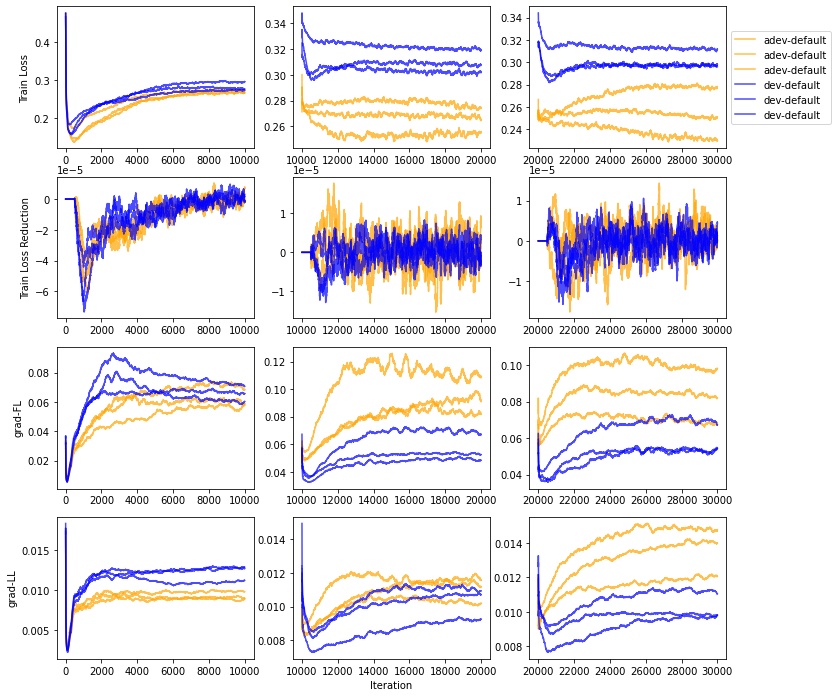

In [14]:
nrow, ncol=4,3
fig,ax = plt.subplots(nrow,ncol, figsize=(ncol*4, nrow*3))

# cols: stages
# rows: train, train_reduction, grad_EFL, grad_ELL, grad-DLL
# colors: dev vs adev
# linestyles: default, MatchedTemporal, MatchedSpatial, MatchedSpatioTemporal

# plot first row
i=0
x='Iteration'
y='Train Loss'
for j in tqdm(range(ncol)):
    cax = ax[i,j]
    stage=j+1
    cstage = df_stages[j]
    for df in cstage:
        cax = plot_df(df, x,y, cax, window=100)
cax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[i,0].set_ylabel(y)

# plot second row
i=1
x='Iteration'
y='Train Loss Reduction'
skiprows=500
for j in tqdm(range(ncol)):
    cax = ax[i,j]
    stage=j+1
    cstage = df_stages[j]
    for df in cstage:
        cax = plot_train_reduction(df, x,y, cax, window=500, skiprows=skiprows)
ax[i,0].set_ylabel(y)

# plot third row
i=2
x='Iteration'
y='grad-FL'
for j in tqdm(range(ncol)):
    cax = ax[i,j]
    stage=j+1
    cstage = df_stages[j]
    for df in cstage:
        cax = plot_df(df, x,y, cax, window=300)
ax[i,0].set_ylabel(y)

# plot next row
i=3
x='Iteration'
y='grad-LL'
for j in tqdm(range(ncol)):
    cax = ax[i,j]
    stage=j+1
    cstage = df_stages[j]
    for df in cstage:
        cax = plot_df(df, x,y, cax, window=300)
ax[i,0].set_ylabel(y)

ax[i,0].set_ylabel(y)

ax[i,1].set_xlabel(x)

In [14]:
# import pandas as pd

# Your existing code to create df_avg
df_avg = df_all.groupby(['Condition', 'Curriculum', 'Iteration']).mean()

# Get unique combinations of [Stage, Condition, Curriculum]
unique_combinations = df_all[['Condition', 'Curriculum']].drop_duplicates()

# Create a dictionary to store dataframes for each combination
dfs_dict = {}

# Iterate over each unique combination and create a dataframe for it
for _, row in unique_combinations.iterrows():
#     stage = row['Stage']
    condition = row['Condition']
    curriculum = row['Curriculum']
    
    # Filter rows that match the current combination using xs method
    df_selected = df_avg.xs((condition, curriculum), level=('Condition', 'Curriculum')).reset_index()
    
    # Store the dataframe in the dictionary using a unique key
    key = f"{curriculum}_{condition}"
    dfs_dict[key] = df_selected

# Now you have separate dataframes for each combination of [Stage, Condition, Curriculum] in the dfs_dict dictionary.
# You can access them using the unique keys and plot the desired values (e.g., grad-ELL vs. iteration).
# For example:



In [15]:
def smoothen(ts, window=300):
    return ts.rolling(window=window, min_periods=1).mean()

In [16]:
iter_per_stage = iter_per_epoch*epoch_per_stage

In [17]:
# dashed_dashes = (8, 4)  # Dash length: 8 points, Space length: 4 points
# dotted_dashes = (1, 1)  # Dot length: 2 points, Space length: 2 points
# dashdot_dashes = (6, 2, 2, 2)  # Dash length: 6 points, Space length: 2 points, Dot length: 2 points, Space length: 2 points
# solid_dashes = (None, None)  # No dash, no space (Solid line)

curr_colors = {'adev': 'tab:orange', 'dev': 'tab:blue'}  # Customize colors as needed
cond_linestyles = {'default': 'solid', 
                   'MatchedTemporal': 'dotted',
                   'MatchedSpatial': 'dashed', 
                  'MatchedSpatioTemporal': 'dashdot'}  # Customize linestyles as needed
cond_alphas = {'default': 0.7, 
                'MatchedSpatial': 0.5,    
               'MatchedTemporal': 0.7,    
               'MatchedSpatioTemporal': 0.9}
# cond_dashes =  {'default': solid_dashes, 
#                    'MatchedTemporal': dotted_dashes,
#                    'MatchedSpatial': dashed_dashes, 
#                   'MatchedSpatioTemporal': dashdot_dashes}  # Customize linestyles as needed

In [18]:
import matplotlib.pyplot as plt

# Matplotlib RC parameters for 2x2 figure layout
params = {
    'figure.figsize': (12, 6),        # Figure size (width, height) in inches
    'axes.titlesize': 12,             # Title font size
    'axes.labelsize': 10,             # Axis label font size
    'legend.fontsize': 10,            # Legend font size
    'xtick.labelsize': 20,            # X-axis tick label font size
    'ytick.labelsize': 20,            # Y-axis tick label font size
    'axes.grid': True,                # Show gridlines
    'axes.grid.axis': 'y',                # Show gridlines
    'axes.grid.which': 'both',        # Both major and minor gridlines
    'grid.linestyle': '--',           # Gridlines style
    'grid.alpha': 0.9,                # Gridlines transparency
    'lines.linewidth': 2.0,           # Line width
    'lines.markersize': 7.0,          # Marker size
    'savefig.dpi': 300,               # Resolution for saved figures
    'savefig.transparent': True,      # Transparent background when saving figures
    'axes.linewidth': 1.,            # Spine linewidth
    'axes.edgecolor': 'black',
}

plt.rcParams.update(params)


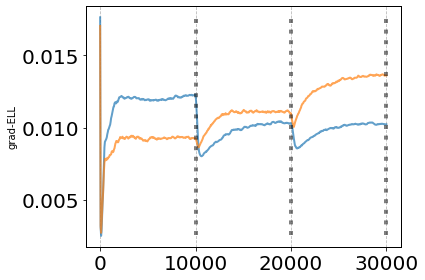

In [19]:
# stages=['1']
conditions=['default']#, 'MatchedSpatial', 'MatchedTemporal', 'MatchedSpatioTemporal']
currs = ['dev', 'adev']

fig, ax = plt.subplots()#figsize=(12, 6))

for cond in conditions:
    for curr in currs:
        key = f"{curr}_{cond}"
        df = dfs_dict[key]
        color = curr_colors[curr]
#         linestyle = cond_linestyles[cond]
        alpha = cond_alphas[cond]
#         dashes = cond_dashes[cond]
        plt.plot(df['Iteration'].iloc[::50], smoothen(df['grad-LL'], window=300).iloc[::50], label=key,
                color=color, alpha=alpha)#linestyle=linestyle)#, dashes=dashes)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel('Iteration')
plt.ylabel('grad-ELL')

for i in range(1,4):
    x_vline = iter_per_stage*i
    plt.axvline(x_vline, ymin=0.05, ymax=0.95, color='k', linestyle='dotted', alpha=0.5, linewidth=4)
plt.grid()
plt.tight_layout()
plt.savefig('jepa_grad-ELLaug1.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('jepa_grad-ELLaug1.png', dpi=300, bbox_inches='tight')

In [20]:
df_avg = df_all.groupby(['Condition', 'Curriculum', 'Iteration']).mean()
df_std = df_all.groupby(['Condition', 'Curriculum', 'Iteration']).std()

# Get unique combinations of [Stage, Condition, Curriculum]
unique_combinations = df_all[['Condition', 'Curriculum']].drop_duplicates()
# Create a dictionary to store dataframes for each combination
dfs_dict = {}
err_dfs_dict = {}

# Iterate over each unique combination and create a dataframe for it
for _, row in unique_combinations.iterrows():
#     stage = row['Stage']
    condition = row['Condition']
    curriculum = row['Curriculum']
    # Filter rows that match the current combination using xs method
    df_selected = df_avg.xs((condition, curriculum), level=('Condition', 'Curriculum')).reset_index()
    err_df_selected = df_std.xs((condition, curriculum), level=('Condition', 'Curriculum')).reset_index()
    # Store the dataframe in the dictionary using a unique key
    key = f"{curriculum}_{condition}"
    dfs_dict[key] = df_selected
    err_dfs_dict[key] = err_df_selected

def get_rows(df, curr, cond):
    unique_seeds = df['Seed'].unique()
    
    dfseeds_list = []
    for seed in unique_seeds:
        dfseeds_list.append(
            df[(df['Curriculum']==curr) &\
               (df['Condition']==cond) &\
               (df['Seed']==seed)
              ]
        )
    return dfseeds_list

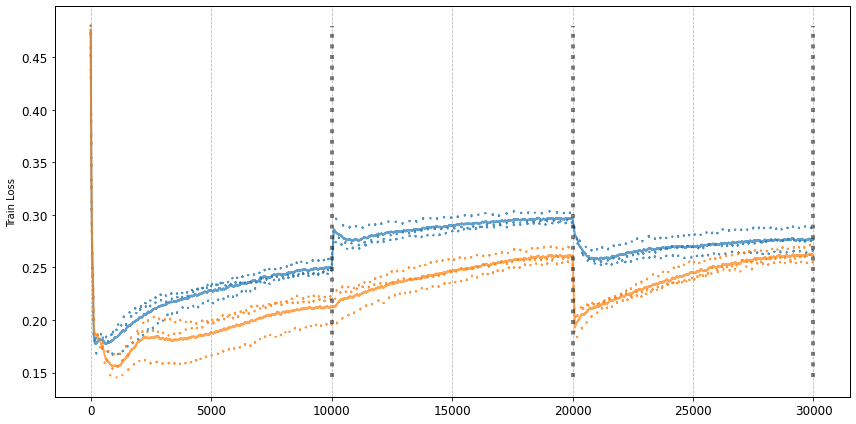

In [33]:
# stages=['1']
conditions=['default']#, 'MatchedSpatial', 'MatchedTemporal', 'MatchedSpatioTemporal']
currs = ['dev', 'adev']
window=100

fig, ax = plt.subplots(figsize=(12, 6))

for cond in conditions:
    for curr in currs:
        key = f"{curr}_{cond}"
        df = dfs_dict[key]
        df_rr = err_dfs_dict[key]
        dfseeds_list = get_rows(df_all, curr, cond)
        color = curr_colors[curr]
        alpha = cond_alphas[cond]
#         plt.errorbar(df['Iteration'], 
#                      smoothen(df['Train Loss'], window=window), 
#                      xerr=None, 
#                      yerr=smoothen(df_rr['Train Loss'], window=window), 
#                      errorevery=500, label=key, color=color, alpha=alpha)
        plt.plot(df['Iteration'], 
                     smoothen(df['Train Loss'], window=window), 
                     label=key, color=color, alpha=alpha)
        for df_seed in dfseeds_list:
            plt.plot(df_seed['Iteration'],
                    smoothen(df_seed['Train Loss'], window=window),
                    color=color, alpha=0.8, linestyle='--', dashes=(1, 10))
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel('Iteration')
plt.ylabel('Train Loss')

for i in range(1,4):
    x_vline = iter_per_stage*i
    plt.axvline(x_vline, ymin=0.05, ymax=0.95, color='k', linestyle='dotted', alpha=0.5, linewidth=4)
plt.grid()
plt.tight_layout()
# plt.savefig('jepa_trainloss_aug81.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('jepa_trainloss_aug81.png', dpi=300, bbox_inches='tight')

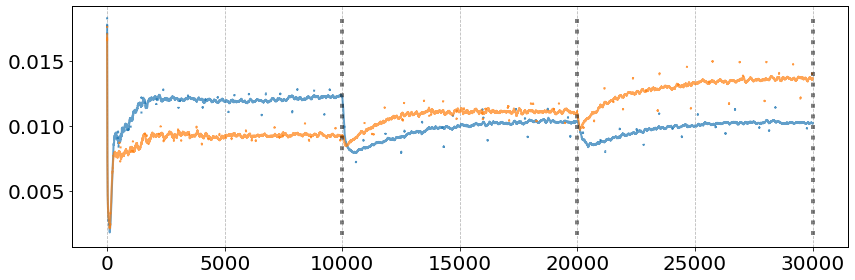

In [21]:
# stages=['1']
conditions=['default']#, 'MatchedSpatial', 'MatchedTemporal', 'MatchedSpatioTemporal']
currs = ['dev', 'adev']
window=100

fig, ax = plt.subplots(figsize=(12, 4))

for cond in conditions:
    for curr in currs:
        key = f"{curr}_{cond}"
        df = dfs_dict[key]
        df_rr = err_dfs_dict[key]
        dfseeds_list = get_rows(df_all, curr, cond)
        color = curr_colors[curr]
        alpha = cond_alphas[cond]
#         plt.errorbar(df['Iteration'], 
#                      smoothen(df['Train Loss'], window=window), 
#                      xerr=None, 
#                      yerr=smoothen(df_rr['Train Loss'], window=window), 
#                      errorevery=500, label=key, color=color, alpha=alpha)
        plt.plot(df['Iteration'], 
                     smoothen(df['grad-LL'], window=window), 
                     label=key, color=color, alpha=alpha)
        for df_seed in dfseeds_list:
            plt.plot(df_seed['Iteration'],
                    smoothen(df_seed['grad-LL'], window=window),
                    color=color, alpha=0.8, linestyle='--', dashes=(1, 100))
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlabel('Iteration')
# plt.ylabel('grad-LL')

for i in range(1,4):
    x_vline = iter_per_stage*i
    plt.axvline(x_vline, ymin=0.05, ymax=0.95, color='k', linestyle='dotted', alpha=0.5, linewidth=4)
plt.grid()
plt.tight_layout()
plt.savefig('jepa_gradLL_'+date+'.pdf', dpi=300, bbox_inches='tight')
plt.savefig('jepa_gradLL_'+date+'.png', dpi=300, bbox_inches='tight')